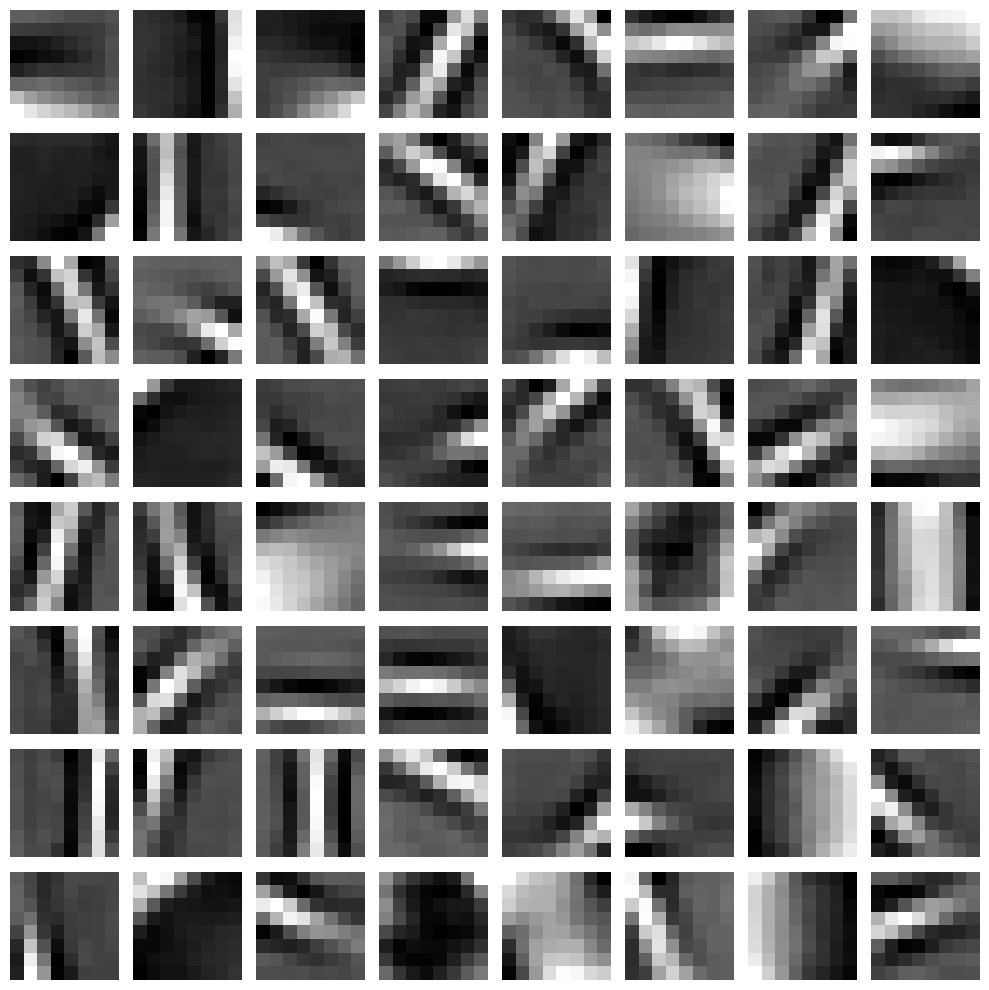

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Load PFs
pfs_path = "C:\\Users\\etcha\\Downloads\\NSCI 247\\Gibbs Sampling\\pfs.npy"
PFs = np.load(pfs_path)  # shape: (64, 64)

fig, axes = plt.subplots(8, 8, figsize=(10,10))
for i, ax in enumerate(axes.flat):
    pf = PFs[i].reshape(8,8)
    ax.imshow(pf, cmap='gray', aspect='equal')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [3]:
from IPython.display import Markdown

Markdown(r"""
**Gibbs Sampling Equation** for the k-th latent:
\[
p(r_k = 1 | I, r_{-k}) = \frac{p(I | r_k=1, r_{-k}) p(r_k=1)}{p(I | r_k=1, r_{-k}) p(r_k=1) + p(I | r_k=0, r_{-k}) p(r_k=0)}
\]
""")



**Gibbs Sampling Equation** for the k-th latent:
\[
p(r_k = 1 | I, r_{-k}) = \frac{p(I | r_k=1, r_{-k}) p(r_k=1)}{p(I | r_k=1, r_{-k}) p(r_k=1) + p(I | r_k=0, r_{-k}) p(r_k=0)}
\]


In [5]:
import numpy as np

def log_gaussian_prob(I, mean, var=0.1):
    # I and mean are vectors of length 64, var is scalar variance
    # log-likelihood under N(mean, var*I)
    diff = I - mean
    return -0.5 * np.sum((diff**2)/var) - 0.5 * 64 * np.log(2*np.pi*var)

def gibbs_sample(I, PFs, num_samples=100, p_prior=0.04, var=0.1):
    """
    Perform Gibbs sampling for binary latents r given image I.
    I: observed image (64-dimensional)
    PFs: shape (64, 64), each row: PF_i
    num_samples: number of samples
    p_prior: prior probability that r_i=1
    var: noise variance (0.1)
    """
    m = PFs.shape[0]  # number of latents (64)
    
    # Initialize r from the prior
    r = np.random.rand(m) < p_prior
    samples = np.zeros((m, num_samples), dtype=bool)

    for s in range(num_samples):
        # For Gibbs sampling, start from the previous sample
        if s > 0:
            r = samples[:, s-1].copy()
        
        # Update each latent in turn
        for k in range(m):
            # Consider flipping r_k
            r_0 = r.copy()
            r_1 = r.copy()
            r_0[k] = 0
            r_1[k] = 1
            
            # Compute means
            mean_0 = PFs.T @ r_0  # sum_i PF_i r_i
            mean_1 = PFs.T @ r_1
            
            # Compute log probabilities
            log_p_I_r0 = log_gaussian_prob(I, mean_0, var)
            log_p_I_r1 = log_gaussian_prob(I, mean_1, var)
            
            # Combine with priors
            p_r0 = (1 - p_prior) * np.exp(log_p_I_r0)
            p_r1 = p_prior * np.exp(log_p_I_r1)
            
            # Probability that r_k=1 given the rest
            p_rk1 = p_r1 / (p_r0 + p_r1)
            
            # Sample from Bernoulli
            r[k] = (np.random.rand() < p_rk1)
            
        samples[:, s] = r
        
    return samples

# Example usage:
# I = PFs[0]  # using one PF as the observed image
# samples = gibbs_sample(I, PFs, num_samples=100)
# samples is a (64,100) matrix of boolean values


In [6]:
def compute_posterior(samples):
    """
    Compute marginal posterior probability for each latent as fraction of times it was 1.
    samples: (m, num_samples) boolean array
    """
    return np.mean(samples, axis=1)

# Example usage:
# posterior = compute_posterior(samples)
# print(posterior)


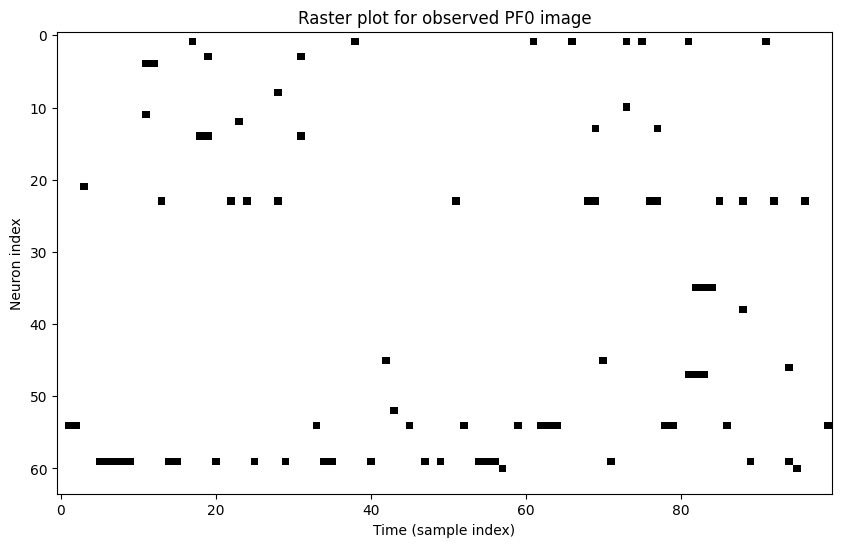

In [7]:
import matplotlib.pyplot as plt

# Let's pick PF #0 as the observed image
I_test = PFs[0]  # shape (64,)

# Run the sampler for 500ms = 500/5 = 100 samples
num_samples = 100
samples_test = gibbs_sample(I_test, PFs, num_samples=num_samples)

# Raster plot: each row is a neuron, each column a time step
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(samples_test, aspect='auto', cmap='binary', interpolation='nearest')
ax.set_xlabel('Time (sample index)')
ax.set_ylabel('Neuron index')
ax.set_title('Raster plot for observed PF0 image')
plt.show()

# You can inspect the pattern of activity and describe behavior separately.


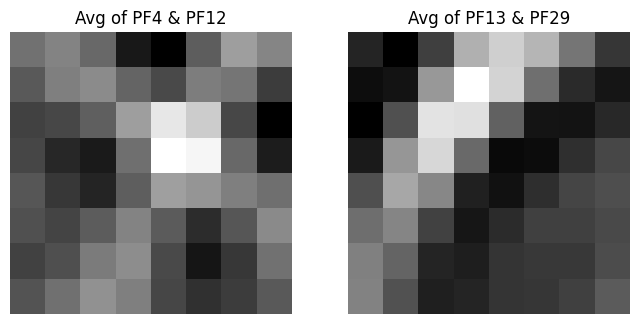

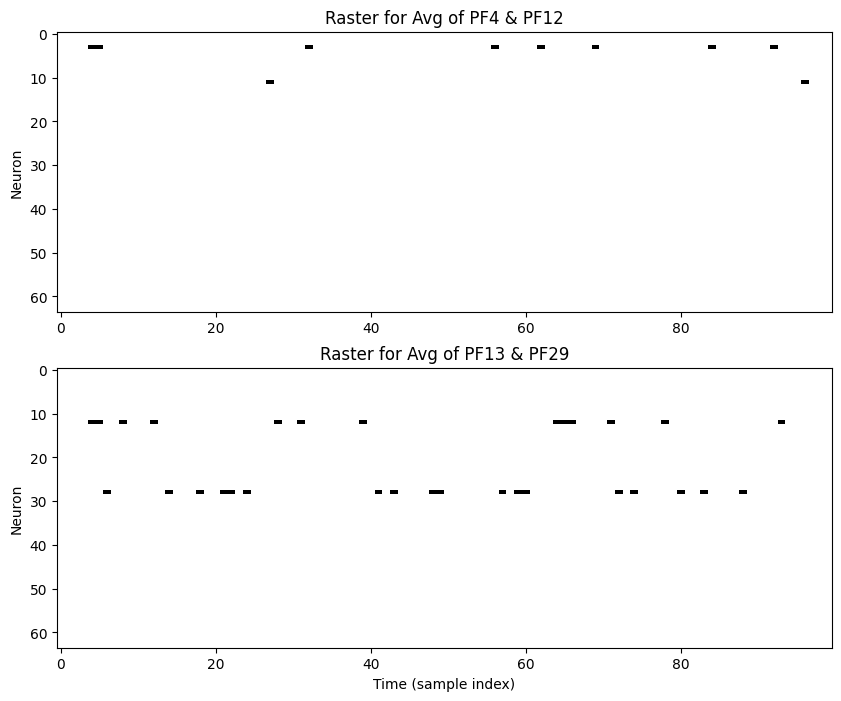

In [30]:
# We'll create a stimulus which is the average of PFs[3] and PFs[11] (0-based indexing)
# corresponding to PFs #4 and #12 in 1-based indexing:
I_avg_4_12 = 0.5 * (PFs[3] + PFs[11])

# Similarly for PFs 13 and 29 (1-based indexing) -> PFs[12] and PFs[28] in 0-based:
I_avg_13_29 = 0.5 * (PFs[12] + PFs[28])

# Display input images
fig, axes = plt.subplots(1,2, figsize=(8,4))
axes[0].imshow(I_avg_4_12.reshape(8,8), cmap='gray')
axes[0].set_title("Avg of PF4 & PF12")
axes[0].axis('off')

axes[1].imshow(I_avg_13_29.reshape(8,8), cmap='gray')
axes[1].set_title("Avg of PF13 & PF29")
axes[1].axis('off')
plt.show()

# Run Gibbs sampling for each and plot raster
samples_4_12 = gibbs_sample(I_avg_4_12, PFs, num_samples=100)
samples_13_29 = gibbs_sample(I_avg_13_29, PFs, num_samples=100)

fig, axes = plt.subplots(2,1, figsize=(10,8))
axes[0].imshow(samples_4_12, aspect='auto', cmap='binary')
axes[0].set_title("Raster for Avg of PF4 & PF12")
axes[0].set_ylabel("Neuron")

axes[1].imshow(samples_13_29, aspect='auto', cmap='binary')
axes[1].set_title("Raster for Avg of PF13 & PF29")
axes[1].set_ylabel("Neuron")
axes[1].set_xlabel("Time (sample index)")
plt.show()


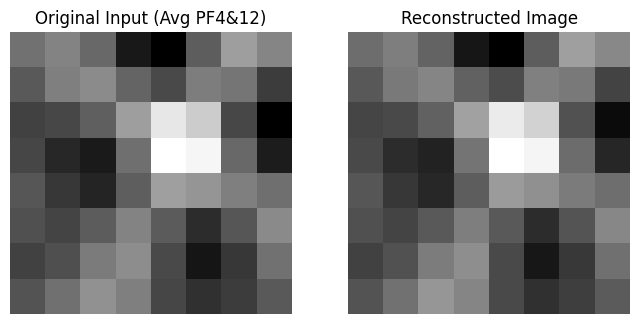

In [29]:
def reconstruct_image_from_samples(PFs, samples):
    # posterior probability = mean of samples along time
    posterior = compute_posterior(samples)
    return PFs.T @ posterior

# Example usage for one of the averaged images:
recon_4_12 = reconstruct_image_from_samples(PFs, samples_4_12)

fig, axes = plt.subplots(1,2, figsize=(8,4))
axes[0].imshow(I_avg_4_12.reshape(8,8), cmap='gray')
axes[0].set_title("Original Input (Avg PF4&12)")
axes[0].axis('off')

axes[1].imshow(recon_4_12.reshape(8,8), cmap='gray')
axes[1].set_title("Reconstructed Image")
axes[1].axis('off')
plt.show()


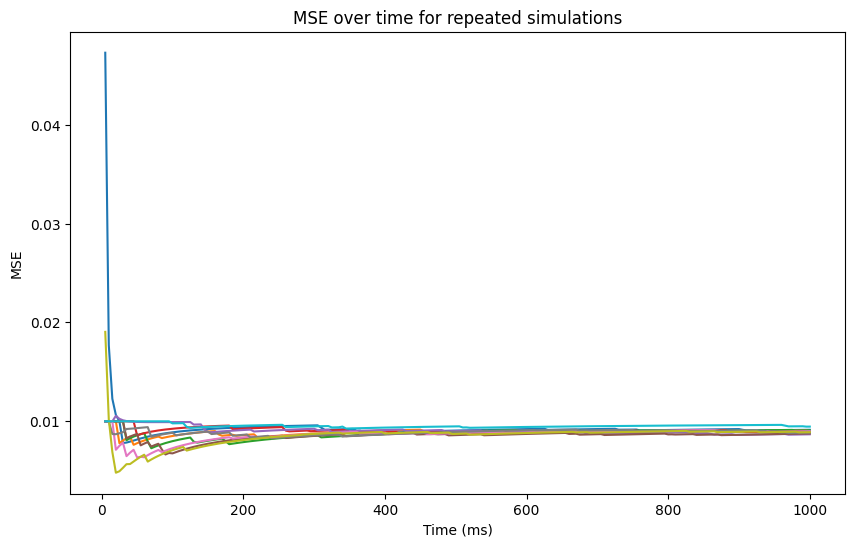

In [10]:
def mse(a, b):
    return np.mean((a - b)**2)

# Track MSE as we get more samples
num_experiments = 10
num_samples = 200  # 1s at 5ms per sample
mse_traces = []

for exp in range(num_experiments):
    samples_tmp = gibbs_sample(I_avg_4_12, PFs, num_samples=num_samples)
    mses = []
    for s in range(1, num_samples+1):
        recon_tmp = reconstruct_image_from_samples(PFs, samples_tmp[:, :s])
        mses.append(mse(recon_tmp, I_avg_4_12))
    mse_traces.append(mses)

# Plot the MSE over time
fig, ax = plt.subplots(figsize=(10,6))
for mses in mse_traces:
    ax.plot(np.arange(1, num_samples+1)*5, mses) # x-axis in ms
ax.set_xlabel('Time (ms)')
ax.set_ylabel('MSE')
ax.set_title('MSE over time for repeated simulations')
plt.show()


In [20]:
def generate_grating(theta, freq, c=0.2, size=8):
    """
    Generate an 8x8 image of a sine-wave grating.

    Parameters:
        theta: orientation in radians
        freq: spatial frequency k
        c: contrast scaling factor
        size: size of the grid (default is 8x8)

    Returns:
        Flattened 64-element array representing the grating pattern.
    """
    x_coords, y_coords = np.meshgrid(np.arange(size), np.arange(size), indexing='xy')
    x_center = x_coords - size / 2
    y_center = y_coords - size / 2
    pattern = c * np.sin(freq * (x_center * np.cos(theta) - y_center * np.sin(theta)))
    return pattern.flatten()  # Ensure output is a 1D array of shape (64,)

# Test parameters
orientations = np.linspace(-np.pi, np.pi, 50)
freqs = [0.25, 0.5, 1.0]


In [24]:
trials_per_stim = 50
stim_duration_ms = 500
samples_per_stim = stim_duration_ms // 5  # 500ms / 5ms = 100 samples

# Reshape PFs to (64, 64)
PFs = PFs.reshape(64, -1)
assert PFs.shape == (64, 64), f"Unexpected shape for PFs: {PFs.shape}"

# For each combination of orientation and frequency, generate image and run sampler multiple times
avg_firing_rates = np.zeros((64, len(orientations), len(freqs)))  # (neurons, orientations, freqs)

for fi, f in enumerate(freqs):
    for oi, theta in enumerate(orientations):
        I_stim = generate_grating(theta, f)
        
        # Debugging: Print shapes to ensure correctness
        print(f"I_stim shape: {I_stim.shape}")
        assert I_stim.shape == (64,), f"Unexpected shape for I_stim: {I_stim.shape}"
        
        total_spikes = np.zeros(64)
        for _ in range(trials_per_stim):
            # Run Gibbs sampling
            print(f"PFs shape: {PFs.shape}")
            samples_stim = gibbs_sample(I_stim, PFs, num_samples=samples_per_stim)
            print(f"samples_stim shape: {samples_stim.shape}")
            
            # Sum spikes over time
            total_spikes += np.sum(samples_stim, axis=1)
        
        # Average firing rate: spikes/trial/500ms
        avg_firing_rates[:, oi, fi] = (total_spikes / trials_per_stim) / (stim_duration_ms / 1000.0)


I_stim shape: (64,)
PFs shape: (64, 64)
samples_stim shape: (64, 100)
PFs shape: (64, 64)
samples_stim shape: (64, 100)
PFs shape: (64, 64)
samples_stim shape: (64, 100)
PFs shape: (64, 64)
samples_stim shape: (64, 100)
PFs shape: (64, 64)
samples_stim shape: (64, 100)
PFs shape: (64, 64)
samples_stim shape: (64, 100)
PFs shape: (64, 64)
samples_stim shape: (64, 100)
PFs shape: (64, 64)
samples_stim shape: (64, 100)
PFs shape: (64, 64)
samples_stim shape: (64, 100)
PFs shape: (64, 64)
samples_stim shape: (64, 100)
PFs shape: (64, 64)
samples_stim shape: (64, 100)
PFs shape: (64, 64)
samples_stim shape: (64, 100)
PFs shape: (64, 64)
samples_stim shape: (64, 100)
PFs shape: (64, 64)
samples_stim shape: (64, 100)
PFs shape: (64, 64)
samples_stim shape: (64, 100)
PFs shape: (64, 64)
samples_stim shape: (64, 100)
PFs shape: (64, 64)
samples_stim shape: (64, 100)
PFs shape: (64, 64)
samples_stim shape: (64, 100)
PFs shape: (64, 64)
samples_stim shape: (64, 100)
PFs shape: (64, 64)
samples_st

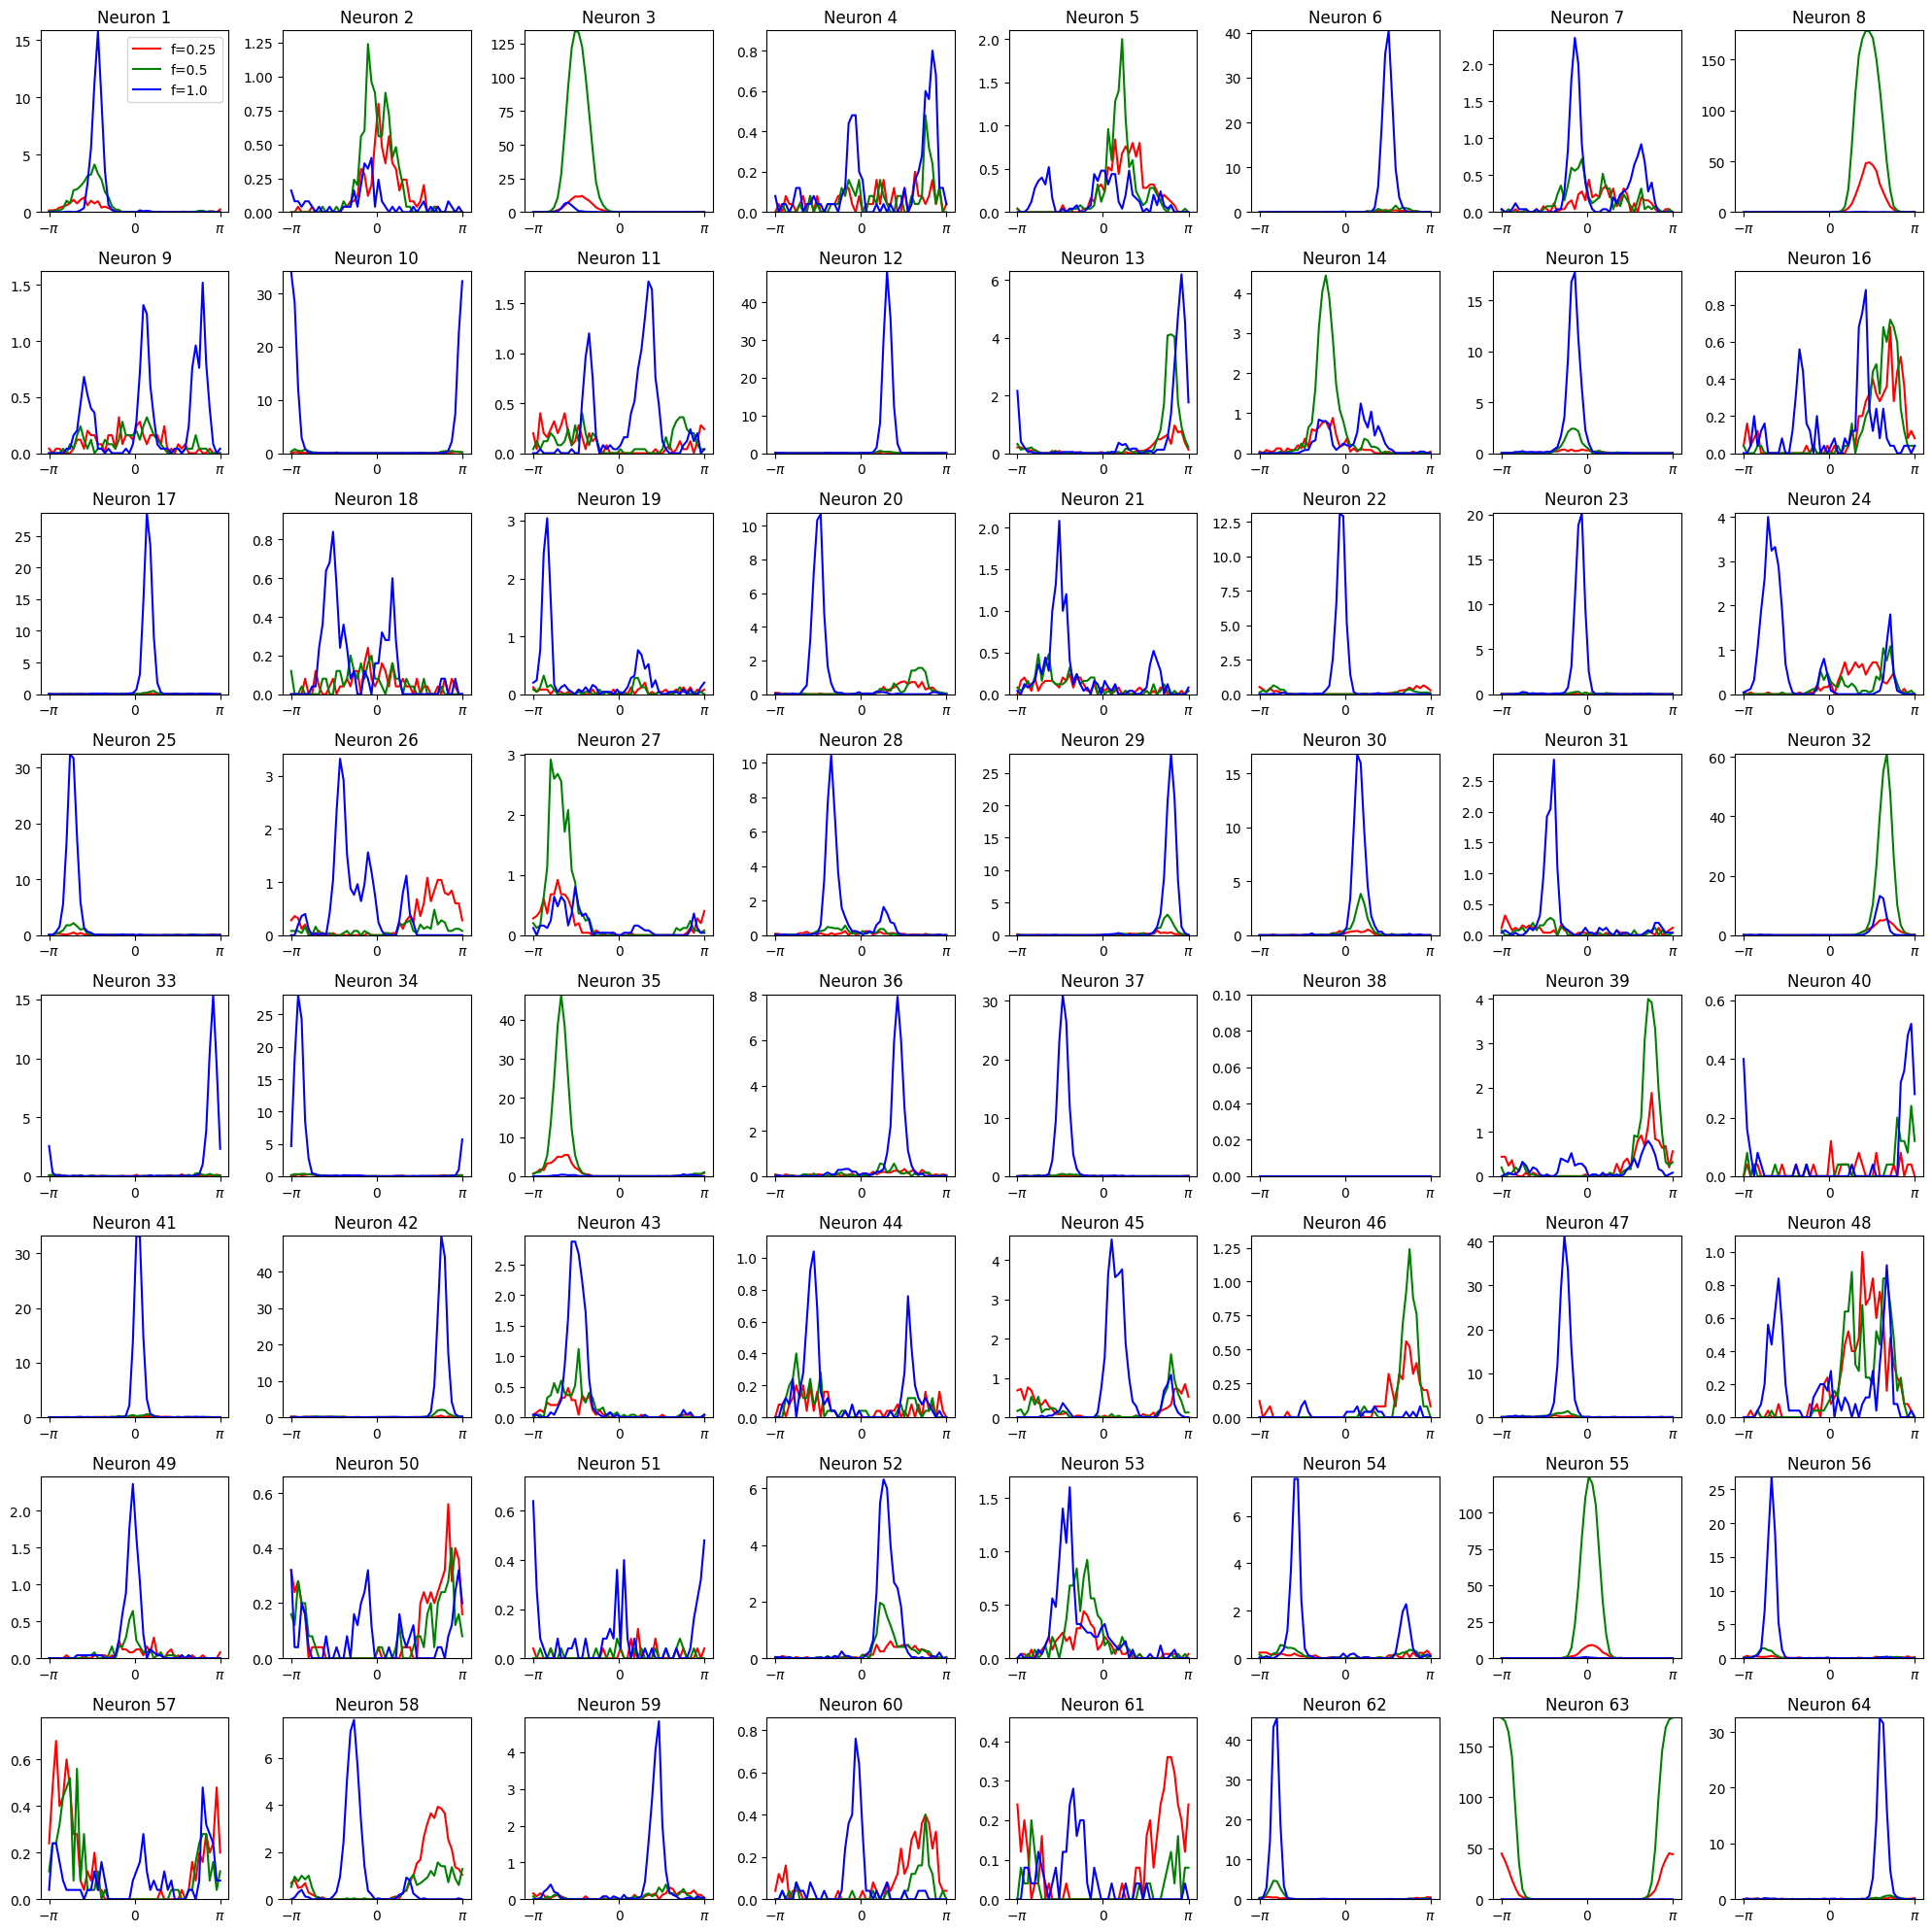

In [25]:
# We have 64 neurons, plot in an 8x8 grid similar to PF visualization
fig, axes = plt.subplots(8, 8, figsize=(20,20))
colors = ['r', 'g', 'b']  # one color per frequency
for i, ax in enumerate(axes.flat):
    for fi in range(len(freqs)):
        ax.plot(orientations, avg_firing_rates[i,:,fi], color=colors[fi], label=f'f={freqs[fi]}')
    ax.set_xticks([-np.pi, 0, np.pi])
    ax.set_xticklabels([r'$-\pi$', '0', r'$\pi$'])
    ax.set_title(f"Neuron {i+1}")
    ax.set_ylim([0, np.max(avg_firing_rates[i,:,:])+0.1])
    
    if i==0:
        ax.legend()

plt.tight_layout()
plt.show()
